# Stock Price Prediction using Time Series Forecasting (ARIMA)

This notebook loads historical stock price data (`stock_prices.csv`), performs preprocessing and exploratory analysis, engineers lag/rolling features, fits an ARIMA model to the Close price, tunes parameters with a small grid search, forecasts future values, and evaluates results (MAE, RMSE, MAPE).  

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Load dataset
df = pd.read_csv("stock_prices.csv")

# Quick peek
print("Rows, cols:", df.shape)
df.head()

Rows, cols: (200, 4)


,Date,Open,Close,Volume
0,2020-01-01,100.854502,100.496714,4170
1,2020-01-02,100.919234,100.358450,1510
2,2020-01-03,102.089190,101.006138,1384
3,2020-01-04,103.582970,102.529168,1404
4,2020-01-05,100.917346,102.295015,3870


In [15]:
# Preprocessing
if 'Date' not in df.columns:
    df.reset_index(inplace=True)  # bring Date back as a column if it's the index

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date (in case)
df = df.sort_values('Date').reset_index(drop=True)

# Handle missing values (simple strategies shown)
print("Missing values before:\n ", df.isnull().sum())

# Option 1: forward-fill then back-fill for small gaps
df[['Open','Close','Volume']] = df[['Open','Close','Volume']].fillna(method='ffill').fillna(method='bfill')

# Option 2: if you prefer drop any remaining NaNs (uncomment)
# df.dropna(inplace=True)

print("Missing values after:\n", df.isnull().sum())

# Set Date as index
df.set_index('Date', inplace=True)

# Ensure numeric types
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

df.head()


Missing values before:
  Date      0
Open      0
Close     0
Volume    0
dtype: int64
Missing values after:
 Date      0
Open      0
Close     0
Volume    0
dtype: int64


,Open,Close,Volume
Date,,,
2020-01-01,100.854502,100.496714,4170
2020-01-02,100.919234,100.358450,1510
2020-01-03,102.089190,101.006138,1384
2020-01-04,103.582970,102.529168,1404
2020-01-05,100.917346,102.295015,3870


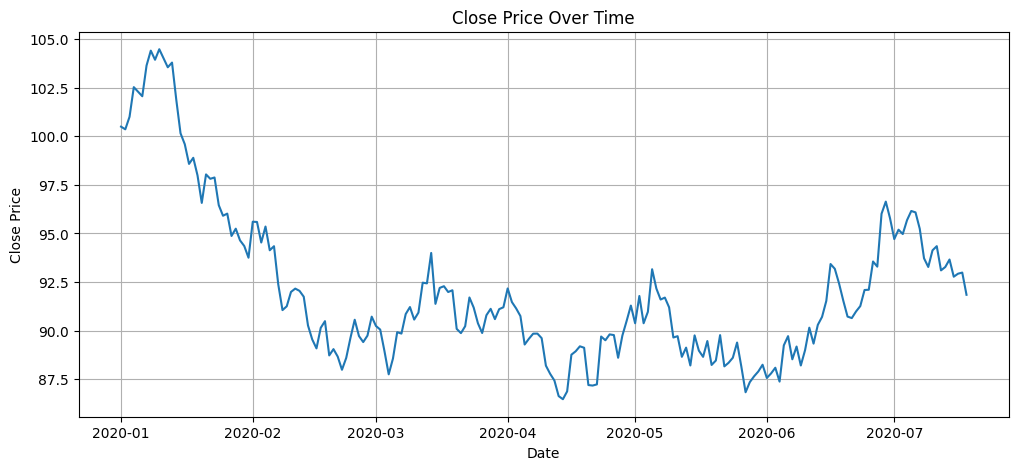

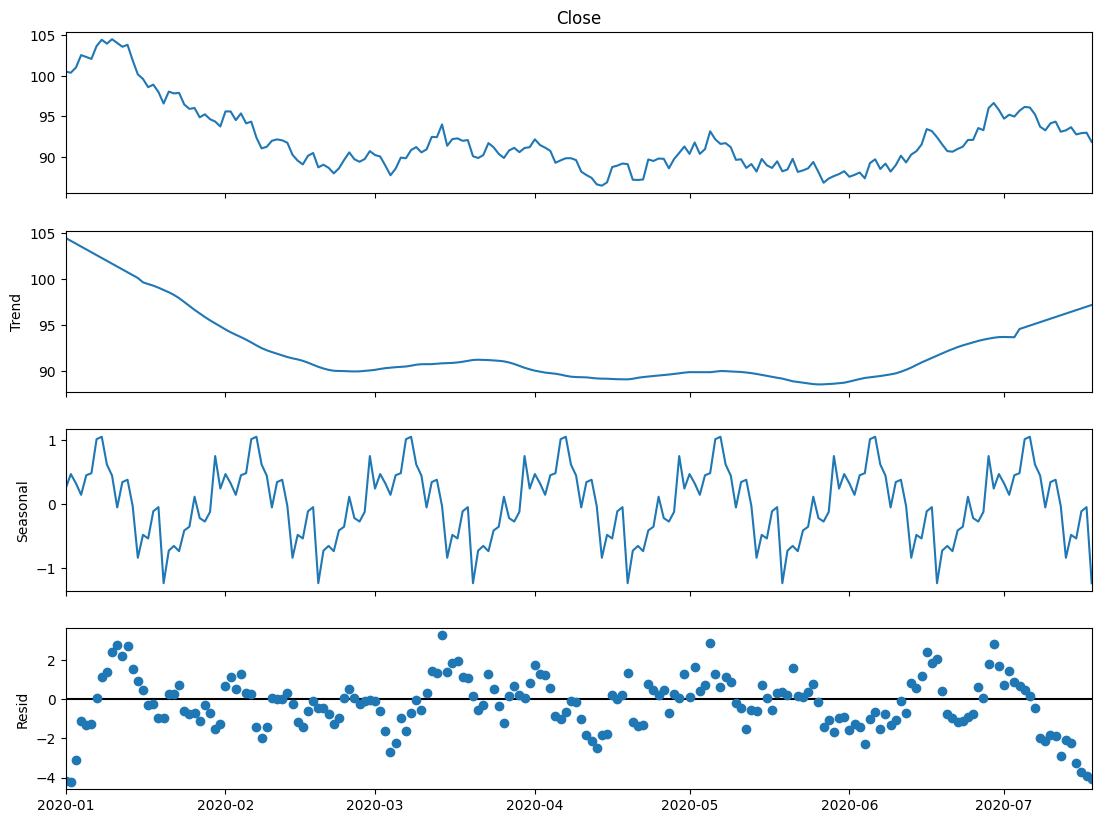

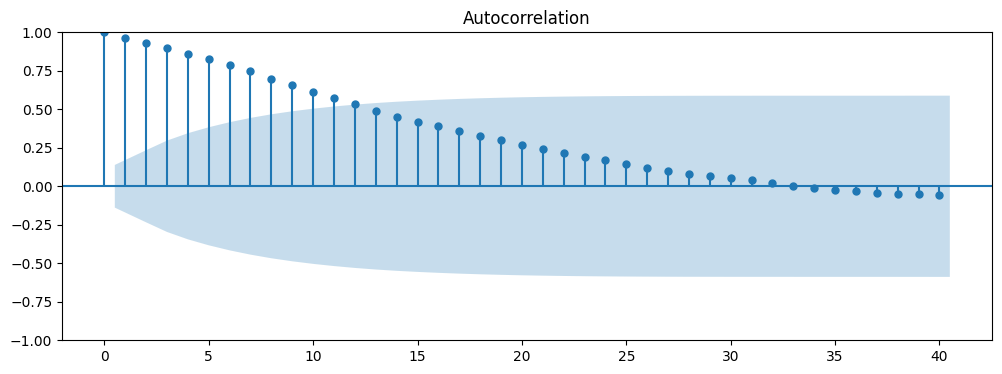

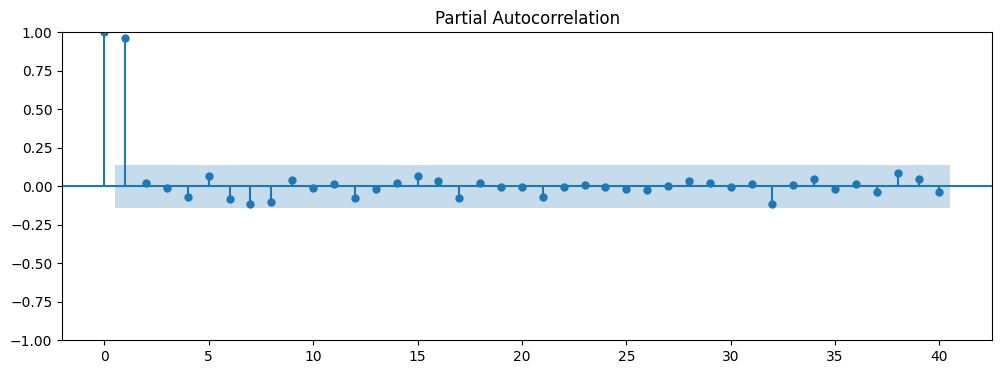

In [16]:
# EDA
# Plot Close price time series
plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

# Decompose time series (if long enough). Use period if known (e.g., 252 trading days)
# For daily synthetic/demo data we use period=30 for monthly-like seasonality; adjust for real stock data.
decompose_period = 30  # change as appropriate for your data (e.g., 252 for trading days)
try:
    decomposition = seasonal_decompose(df['Close'], period=decompose_period, model='additive', extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(12,9)
    plt.show()
except Exception as e:
    print("Decomposition error (likely insufficient length or bad period):", e)

# ACF and PACF
plt.figure(figsize=(12,4))
plot_acf(df['Close'].dropna(), lags=40, ax=plt.gca())
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df['Close'].dropna(), lags=40, ax=plt.gca(), method='ywm')
plt.show()

In [17]:
# Feature Engineering
# Create lag features (previous day close)
df_feat = df.copy()
df_feat['lag1'] = df_feat['Close'].shift(1)
df_feat['lag2'] = df_feat['Close'].shift(2)

# Rolling windows
df_feat['ma7'] = df_feat['Close'].rolling(window=7).mean()
df_feat['ma21'] = df_feat['Close'].rolling(window=21).mean()
df_feat['std21'] = df_feat['Close'].rolling(window=21).std()

# Drop NA rows introduced by shifting/rolling
df_feat = df_feat.dropna()

df_feat.head()

,Open,Close,Volume,lag1,lag2,ma7,ma21,std21
Date,,,,,,,,
2020-01-21,100.354336,98.039678,1082,96.574029,97.986332,98.546096,101.346550,2.420962
2020-01-22,95.946636,97.813901,2168,98.039678,96.574029,98.211621,101.218797,2.536098
2020-01-23,98.567690,97.881429,4156,97.813901,98.039678,97.967119,101.100843,2.633832
2020-01-24,94.843965,96.456681,4149,97.881429,97.813901,97.663772,100.884203,2.822367
2020-01-25,95.440367,95.912299,3504,96.456681,97.881429,97.237764,100.569113,2.993695


In [18]:
# Train/test split for forecasting 
# We'll forecast the 'Close' series using only past Close values (univariate ARIMA).
series = df['Close'].dropna()

# Train/test split (e.g., 80/20)
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

print(f"Train length: {len(train)}, Test length: {len(test)}")

Train length: 160, Test length: 40


In [19]:
# Optional: simple grid search to choose p,d,q by AIC
# WARNING: grid search can be slow. Use a small grid for demo.
import itertools
import warnings
warnings.filterwarnings("ignore")

p_vals = [0,1,2,3]
d_vals = [0,1]
q_vals = [0,1,2]

best_aic = np.inf
best_order = None
best_model = None

print("Starting small grid search for (p,d,q) by AIC...")

for p,d,q in itertools.product(p_vals, d_vals, q_vals):
    try:
        model = ARIMA(train, order=(p,d,q))
        model_fit = model.fit()
        aic = model_fit.aic
        # print(f"Order {(p,d,q)} AIC={aic:.2f}")
        if aic < best_aic:
            best_aic = aic
            best_order = (p,d,q)
            best_model = model_fit
    except Exception as e:
        # skip non-converging models
        # print("Failed for", (p,d,q), e)
        continue

print("Best order by AIC:", best_order, "AIC:", best_aic)

Starting small grid search for (p,d,q) by AIC...
Best order by AIC: (0, 1, 0) AIC: 432.9134120613685


In [20]:
# Fit ARIMA with chosen order
# If grid-search produced a model, use it. Otherwise pick manual (5,1,0) as fallback.
if best_model is not None:
    model_fit = best_model
    chosen_order = best_order
else:
    chosen_order = (5,1,0)
    model_fit = ARIMA(train, order=chosen_order).fit()

print("Using ARIMA order:", chosen_order)

# Forecast for the test period length
n_steps = len(test)
forecast = model_fit.forecast(steps=n_steps)

# Align forecast index with test
forecast = pd.Series(forecast, index=test.index)

Using ARIMA order: (0, 1, 0)


In [21]:
# Evaluation metrics
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae = mean_absolute_error(test, forecast)
rmse = math.sqrt(mean_squared_error(test, forecast))
mape_val = mape(test, forecast)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape_val:.2f}%")

MAE: 3.8004
RMSE: 4.2916
MAPE: 4.04%


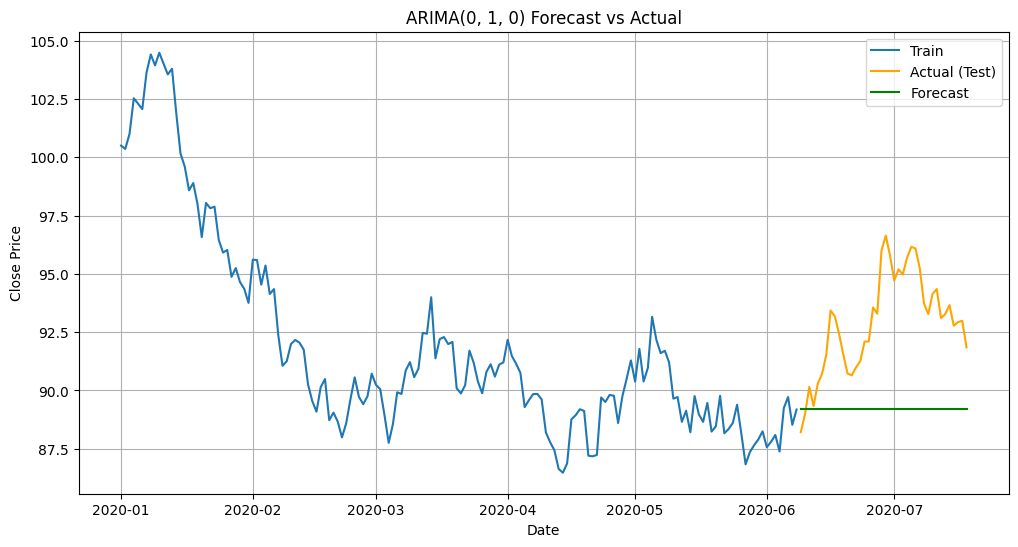

In [22]:
# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual (Test)', color='orange')
plt.plot(forecast.index, forecast, label='Forecast', color='green')
plt.title(f"ARIMA{chosen_order} Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Save model & forecast

# Save forecast CSV
forecast_df = pd.DataFrame({'actual': test, 'forecast': forecast})
forecast_df.to_csv("forecast_vs_actual.csv", index=True)
print("Saved forecast_vs_actual.csv")

# Save fitted ARIMA results (pickle)
try:
    import pickle
    with open("arima_model_fit.pkl", "wb") as f:
        pickle.dump(model_fit, f)
    print("Saved arima_model_fit.pkl")
except Exception as e:
    print("Could not pickle model:", e)

Saved forecast_vs_actual.csv
Saved arima_model_fit.pkl


### Notes & next steps
- For production use with real stock data:
  - Use business-day frequency and align to trading calendar (e.g., remove weekends).
  - Consider external regressors (exogenous variables) such as volume, technical indicators, or macro features (ARIMAX).
  - Use a more robust parameter search (auto_arima from `pmdarima`) or cross-validation for time series (rolling origin).
  - Combine ARIMA with machine learning models (hybrid) or try Prophet, LSTM, or other deep-learning models for improved performance.
- Always be cautious: stock forecasting is inherently noisy and non-stationary. Backtest thoroughly and avoid overfitting.